# KimCNN
https://towardsdatascience.com/identifying-hate-speech-with-bert-and-cnn-b7aa2cddd60d

In [1]:
%matplotlib inline

In [2]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

from utils import *

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.7
pandas==1.0.3
numpy==1.19.1
torch==1.6.0
sklearn==0.23.1
transformers==3.0.2
matplotlib==3.3.0


In [4]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

# hyperparams & corpus

In [5]:
SAMPLE_SIZE = 140
LABEL_COL = "rating"
MAX_SEQ = 100

TRAIN_SIZE = 0.6

EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.01

In [6]:
df = pd.read_csv('../corpora/small_amazon_reviews_electronic.csv')
df = df.sample(SAMPLE_SIZE)
df.shape

(140, 6)

In [7]:
df.head(2)

,rating,name,review,verified,vote,date
56116,4.0,Matthew Throne,Being able to weigh it down is a nice addition...,True,0.0,27.01.2018
51262,4.0,Johnboy7701,Works well could be a little stronger,True,0.0,25.06.2018


In [8]:
TRAIN_IDX = int(df.shape[0] * TRAIN_SIZE)
VAL_IDX = int(TRAIN_IDX) + int((df.shape[0] * (1-TRAIN_SIZE))/2)

In [9]:
df_train = df[:TRAIN_IDX].reset_index(drop=True)
df_val = df[TRAIN_IDX:VAL_IDX].reset_index(drop=True)
df_test = df[VAL_IDX:].reset_index(drop=True)

In [10]:
print(df_train.shape, df_val.shape, df_test.shape)

(84, 6) (28, 6) (28, 6)


# BERT

In [11]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [12]:
%%time
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

CPU times: user 3.38 s, sys: 1.04 s, total: 4.43 s
Wall time: 8.48 s


In [13]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.review.values
    ]

def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text, dtype=torch.long)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.long)

In [14]:
train_indices = tokenize_and_pad_text(df_train, MAX_SEQ)
val_indices = tokenize_and_pad_text(df_val, MAX_SEQ)
test_indices = tokenize_and_pad_text(df_test, MAX_SEQ)

In [15]:
train_indices

tensor([[ 101, 2108, 2583,  ...,    0,    0,    0],
        [ 101, 2573, 2092,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ..., 2000, 2031, 2330],
        ...,
        [ 101, 7929, 3737,  ...,    0,    0,    0],
        [ 101, 2049, 1037,  ..., 4057, 2068, 2000],
        [ 101, 1996, 2132,  ...,    0,    0,    0]])

In [16]:
%%time
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

CPU times: user 1min 12s, sys: 2.62 s, total: 1min 14s
Wall time: 44 s


In [17]:
y_train = targets_to_tensor(df_train, LABEL_COL)
y_val = targets_to_tensor(df_val, LABEL_COL)
y_test = targets_to_tensor(df_test, LABEL_COL)

In [18]:
print(x_train[0].shape, x_train[0])

torch.Size([100, 768]) tensor([[-0.2582, -0.0506,  0.2093,  ...,  0.0064,  0.7348, -0.2861],
        [-0.2798, -0.0714, -0.8908,  ...,  0.3321,  0.9854,  0.3146],
        [-0.2897, -0.0796,  0.1219,  ...,  0.1095,  0.4294, -0.1900],
        ...,
        [ 0.3450, -0.2605,  0.9711,  ..., -0.7647,  0.3504, -1.2968],
        [ 0.1684, -0.2694,  0.9803,  ..., -0.7790,  0.2555, -1.2936],
        [ 0.2664, -0.1511,  0.7620,  ..., -0.8262,  0.2276, -1.4162]])


In [30]:
class KimCNN(nn.Module):
    """ Conv2d(in_channel = 1, 
           out_channel = 3,
           kernel_size = (2,768) oder (3,768) oder (4,768))
    """ 
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num # maximum number of words in review
        D = embed_dim # 768
        C = class_num # 5
        Co = kernel_num # number of filters for each convolution operation
        Ks = kernel_sizes # e.g. combinations of 2, 3, 4, ... words
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([
            nn.Conv2d(1, Co, (K, D)) for K in Ks
          ])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        
        # OLD: self.sigmoid = nn.Sigmoid()
        # TODO
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        if self.static:
            x = Variable(x)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        # OLD: output = self.sigmoid(logit)
        # TODO
        # output = self.softmax(logit)
        return logit
    

- **embed_num** represents the maximum number of words in a comment (100 in this example).
- **embed_dim** represents the size of BERT embedding (768).
- **class_num** is the number of toxicity threats to predict (6).
- **kernel_num** is the number of filters for each convolution operation (eg. 3 filters for [2 x m] convolution).
- **kernel_sizes** of convolutions. Eg. look at combinations 2 words, 3 words, etc.
- **dropout** is the percentage of randomly set hidden units to 0 at each update of the training phase. Tip: Make sure you disable dropout during test/validation phase to get deterministic output.
- **static** parameter True means that we don’t calculate gradients of embeddings and they stay static. If we set it to False, it would increase the number of parameters the model needs to learn and it could overfit.

In [31]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = 6
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True


model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [32]:
model

KimCNN(
  (embed): Embedding(100, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=6, bias=True)
)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [24]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [45]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

#x_train = x_train.long()
#y_train = y_train.long()

for epoch in range(1, EPOCHS+1):
    start_time = time.time()
    train_loss = 0
    train_acc = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, BATCH_SIZE):
        #x_batch = x_batch.long()
        #y_batch = y_batch.long()
        
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        acc = categorical_accuracy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= batch
    train_acc /= batch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    elapsed = time.time() - start_time
    

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        val_acc = 0
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, BATCH_SIZE):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            acc = categorical_accuracy(y_pred, y_batch)
            val_loss += loss.item()
            val_acc += acc.item()
        val_loss /= batch
        val_acc /= batch
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
    def rnd(n):
        return np.around(n, decimals=3)
    
    print(f"Epoch {epoch} ({rnd(elapsed)}s)")
    print(f"Train loss: {rnd(train_losses[-1])} | Val Loss: {rnd(val_losses[-1])}")
    print(f"Train acc: {rnd(train_accuracies[-1]*100)}% | Val acc: {rnd(val_accuracies[-1]*100)}%") 
    print("----------------------------------------")

Epoch 1 (1.119s)
Train loss: 0.339 | Val Loss: 2.005
Train acc: 85.417% | Val acc: 23.958%
----------------------------------------
Epoch 2 (0.898s)
Train loss: 0.474 | Val Loss: 1.963
Train acc: 78.125% | Val acc: 28.125%
----------------------------------------
Epoch 3 (0.889s)
Train loss: 0.526 | Val Loss: 1.944
Train acc: 70.833% | Val acc: 35.417%
----------------------------------------
Epoch 4 (0.893s)
Train loss: 0.372 | Val Loss: 1.979
Train acc: 81.25% | Val acc: 36.458%
----------------------------------------
Epoch 5 (0.984s)
Train loss: 0.441 | Val Loss: 1.986
Train acc: 79.167% | Val acc: 39.583%
----------------------------------------
Epoch 6 (1.012s)
Train loss: 0.408 | Val Loss: 1.983
Train acc: 80.208% | Val acc: 35.417%
----------------------------------------
Epoch 7 (1.646s)
Train loss: 0.469 | Val Loss: 2.04
Train acc: 76.042% | Val acc: 28.125%
----------------------------------------
Epoch 8 (2.592s)
Train loss: 0.484 | Val Loss: 2.06
Train acc: 78.125% | Val a

Text(0.5, 1.0, 'Losses')

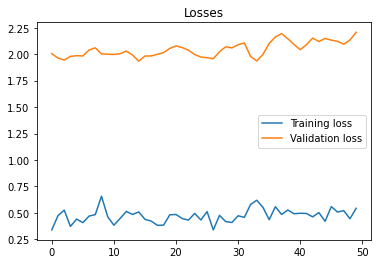

In [46]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [93]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, BATCH_SIZE):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [94]:
y_preds_np

array([[-0.25008011,  0.15140831,  0.75387979,  0.77974641,  0.3716363 ,
         0.9738462 ],
       [-0.94829065,  0.23531982,  0.83165634,  1.54329777,  1.14960456,
         1.16471028],
       [-0.48482552,  0.39177954,  0.78040463,  1.23994446,  0.87735057,
         1.00564682],
       [-0.9384107 ,  1.64808559,  0.4806627 ,  1.81574142,  1.49107528,
         1.08294749],
       [-0.67829269,  0.0891971 ,  0.43799555,  0.86421561,  0.57455552,
         0.78969955],
       [-0.73730791,  1.43386567,  0.73605382,  1.66408563,  1.28786242,
         1.10473347],
       [-0.37489676,  0.54627359,  0.94118488,  1.16473258,  0.71518099,
         1.30123246],
       [-1.17724597,  0.08536696,  0.71791536,  1.86519945,  1.67288768,
         0.7148447 ],
       [-0.20030463,  0.68846339,  0.80267853,  1.0018332 ,  0.61734319,
         1.03747559],
       [-0.71334618,  1.32633471,  0.78794098,  1.67961109,  1.22302091,
         1.29960382],
       [-0.7080245 ,  0.97795302,  0.74817371,  1.

In [39]:
y_test_np = df_test[target_columns].values

In [40]:
y_test_np[10:]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [58]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [59]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

22

In [60]:
all_labels = df_train[target_columns].count().sum()
all_labels

600

In [61]:
positive_labels/all_labels

0.03666666666666667

In [63]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [64]:
df_sanity

,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df_test_targets.sum()

toxic            2
severe_toxic     0
obscene          2
threat           0
insult           1
identity_hate    0
dtype: int64

In [66]:
df_pred_targets.sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [67]:
df_sanity[df_sanity.toxic > 0][['toxic', 'toxic_pred']]

,toxic,toxic_pred
7,1,0
17,1,0


## leftovers

In [160]:
# ALTERNATIVE
class KimCNN(nn.Module):
    
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        Ci = 1

        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)

        if self.static:
            self.embed.weight.requires_grad = False

    def forward(self, x):
        x = self.embed(x)  # (N, W, D)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit
    
import torch
import torch.nn as nn
import torch.nn.functional as F

#ALTERNATIVE 2
class KimCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # The in_channels argument is the number of "channels" in your image going into the convolutional layer.
        # In actual images this is usually 3 (one channel for each of the red, blue and green channels),
        # however when using text we only have a single channel, t
        # he text itself. The out_channels is the number of filters and the kernel_size is the size of the filters.
        # Each of our kernel_sizes is going to be [n x emb_dim] where $n$ is the size of the n-grams.

        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=n_filters,
                      kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)

        # embedded = [batch size, sent len, emb dim]

        # In PyTorch, RNNs want the input with the batch dimension second, whereas CNNs want the batch dimension first
        # - we do not have to permute the data here as we have already set batch_first = True in our TEXT field.
        # We then pass the sentence through an embedding layer to get our embeddings.
        # The second dimension of the input into a nn. Conv2d layer must be the channel dimension.
        # As text technically does not have a channel dimension,
        # we unsqueeze our tensor to create one.
        # This matches with our in_channels=1 in the initialization of our convolutional layers.

        embedded = embedded.unsqueeze(1)

        # embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))

        # cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

    def predict_class(self, sentence, nlp, dataset, device, min_len=4):
        self.eval()
        tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
        if len(tokenized) < min_len:
            tokenized += ['<pad>'] * (min_len - len(tokenized))
        indexed = [dataset.TEXT.vocab.stoi[t] for t in tokenized]
        tensor = torch.LongTensor(indexed).to(device)
        tensor = tensor.unsqueeze(1)
        tensor = tensor.permute(1, 0)
        preds = self(tensor)
        max_preds = preds.argmax(dim=1)

        return max_preds.item()

    @staticmethod
    def __count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)